In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt
from utils import *
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import hdbscan
import warnings
import os
from geopy.distance import great_circle
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from dtw import *
from haversine import haversine
from sklearn.neighbors import NearestNeighbors
import panel as pn
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(8,4), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=600, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}
# os.environ['GDAL_DATA'] = r'/slurm/home/yrd/luolab/zhaoliang/.conda/envs/py310/Library\share\gdal'


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
df = pd.read_csv('intersection_2021_72.csv')

In [3]:
# define the boundary
df_traj = df[df['Lng'] > -5.8]
df_traj = df_traj[df_traj['Lng'] < 32.3]
df_traj = df_traj[df_traj['Lat'] < 44.6]
df_traj = df_traj[df_traj['Lat'] > 1.135]

# Gibraltar Strait
area_of_gs = Polygon([(-6, 35.8), (-5,  35.8), (-5, 36.2), (-6, 36.2)]) 

# Suez Canal
area_of_sc = Polygon([(32, 31.3), (32.6,  31.3), (32.6, 31.7), (32, 31.7)]) # Suez canal

gdf = gpd.GeoDataFrame(df_traj, geometry=gpd.points_from_xy(df_traj.Lng, df_traj.Lat))

traj_collection = mpd.TrajectoryCollection(gdf, 'LLI NO', t='t', crs="EPSG:4326 WGS84")
traj = find_intersection(traj_collection, area_of_gs, area_of_sc)

print(f"Found {len(traj)} trajectories between Gibraltar Strait and Suez Canal")


Found 473 trajectories
Found 473 trajectories between Gibraltar Strait and Suez Canal


In [4]:
# from india to suez canal
traj_list_sc2gs = [traje for traje in traj if traje.get_start_location().intersects(area_of_sc)]
traj_list_gs2sc = [traje for traje in traj if traje.get_start_location().intersects(area_of_gs)]

print(f"Found {len(traj_list_sc2gs)} trajectories from Suez canal to Gibraltar Strait")
print(f"Found {len(traj_list_gs2sc)} trajectories from Gibraltar Strait to Canal")

traj_collection_gs2sc = mpd.TrajectoryCollection(traj_list_gs2sc)
traj_collection_sc2gs = mpd.TrajectoryCollection(traj_list_sc2gs)

Found 253 trajectories from Suez canal to Gibraltar Strait
Found 220 trajectories from Gibraltar Strait to Canal


## OD flow analysis

In [5]:
# traj_collection_sc2gs_DP = DPcompression(traj_collection_sc2gs, 0.5)
# traj_collection_gs2sc_DP = DPcompression(traj_collection_gs2sc, 0.5)
traj_DP = DPcompression(traj, 0.5)
print("Compression done")


Compression done


In [6]:
from OD_cluster import *

aggregator = OD_cluster(traj_DP, max_distance=0, min_distance=0,min_stop_duration=timedelta(hours=24))
flows = aggregator.get_flows_gdf()
clusters = aggregator.return_clusters_gdf()

Extracting significant points ...
Clustering significant points ...
Computing flows ...


In [7]:
flows.hvplot(title='Generalized aggregated trajectories', geo=True, hover_cols=['weight'], line_width=10, alpha=0.3, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) * clusters.hvplot(geo=True, c = 'n', size='n', tiles='EsriNatGeo', cmap='spring') 


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (weight)
   .WMTS.II  :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (n)

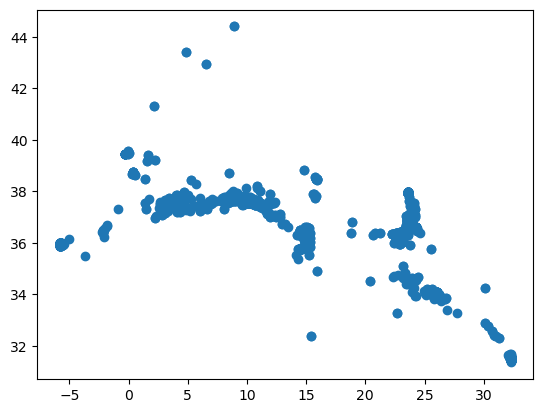

In [8]:
points = aggregator.significant_points

xs = [point.x for point in points]
ys = [point.y for point in points]

X = np.array([(point.x, point.y) for point in points])


plt.scatter(xs, ys)

In [9]:
aggregator, flows, clusters = OD_compute(traj_collection_sc2gs_DP,6, 2, 24)
flows.hvplot(title='Generalized aggregated trajectories', geo=True, hover_cols=['weight'], line_width=10, alpha=0.3, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) * clusters.hvplot(geo=True, c = 'n', size='n', tiles='EsriNatGeo', cmap='spring') 

NameError: name 'traj_collection_sc2gs_DP' is not defined

In [ ]:

aggregator, flows, clusters = OD_compute(traj_collection_gs2sc_DP, 5, 2, 12)
flows.hvplot(title='Generalized aggregated trajectories', geo=True, hover_cols=['weight'], line_width=10, alpha=0.3, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) * clusters.hvplot(geo=True, c = 'n', size='n', tiles='EsriNatGeo', cmap='spring') 

In [ ]:

aggregator, flows, clusters = OD_compute(traj_DP,5, 3, 24)
flows.hvplot(title='Movement patterns of ships', geo=True, hover_cols=['weight'], line_width=10, alpha=0.3, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) * clusters.hvplot(geo=True, c = 'n', size='n', tiles='EsriNatGeo', cmap='spring') 